In [1]:
# set up the environment
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import subprocess

In [58]:
df = pd.read_csv("../data/phages_per_genome.tsv.gz", delimiter='\t', compression='gzip')
df.head()

,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16,2,1,13,48916
1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31,1,10,20,40297
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38,6,13,19,268081
3,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46,6,11,29,166286
4,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33,3,9,21,93416


# Which Version Are You Using?

In [26]:
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {df.shape[0]:,} genomes parsed and {df['Total Predicted Prophages'].sum():,} total prophages")

Please note that this was run with git commit 6004ad0 that has 210,591 genomes parsed and 7,002,139 total prophages


In [4]:
# this should be fixed in the next release and could be removed.
# df = df.replace([np.nan], 0)

In [65]:
df['fraction pp'] = df['bp prophage']/df['Genome length']

## Compare genome length and prophage bp

Use statistics!

In [6]:
exog = sm.add_constant(df["Genome length"])
model = sm.OLS(df["bp prophage"], exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            bp prophage   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                 1.999e+05
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:02:28   Log-Likelihood:            -2.6236e+06
No. Observations:              210591   AIC:                         5.247e+06
Df Residuals:                  210589   BIC:                         5.247e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.777e+04    345.733    -80.327      0.000   -2.84e+04   -2.71e+04
Genome length     0.0380   8.51e-05    447.113      0.000       0.038       0.038
==============================================================================
Omnibus:                    31450.937   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229669.436
Skew:                           0.518   Prob(JB):                         0.00
Kurtosis:                       8.010   Cond. No.                     1.04e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
print(f"The equation is {model.params['Genome length']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for genome length is {model.pvalues['Genome length']:.3f}")

The equation is 0.038x + -27771.579
The R-squared is 0.487
The p-value for genome length is 0.000


In [8]:
df['bp pp fit'] = (model.params['Genome length'] * df['Genome length']) + model.params['const']

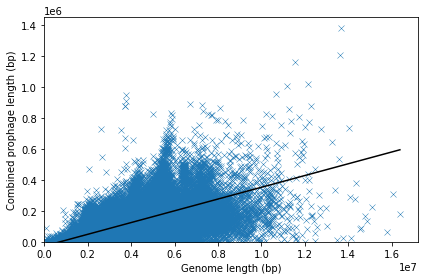

In [9]:
ax = sns.scatterplot(x='Genome length', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Genome length', y='bp pp fit', data=df, color='k')
ax.set_ylabel('Combined prophage length (bp)')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/lengths.png')

## Compare number of prophages and genome length

In [10]:
exog = sm.add_constant(df["Genome length"])
keptmodel = sm.OLS(df["Kept"], exog).fit()
keptmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Kept   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                 1.475e+05
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:05:22   Log-Likelihood:            -5.3331e+05
No. Observations:              210591   AIC:                         1.067e+06
Df Residuals:                  210589   BIC:                         1.067e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.2349      0.017    -73.037      0.000      -1.268      -1.202
Genome length  1.598e-06   4.16e-09    384.044      0.000    1.59e-06    1.61e-06
==============================================================================
Omnibus:                    59058.130   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           431855.390
Skew:                           1.156   Prob(JB):                         0.00
Kurtosis:                       9.624   Cond. No.                     1.04e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
print(f"The equation is {keptmodel.params['Genome length']}x + {keptmodel.params['const']:.3f}")
print(f"The R-squared is {keptmodel.rsquared:.3f}")
print(f"The p-value for genome length is {keptmodel.pvalues['Genome length']:.3f}")

The equation is 1.5978019823960937e-06x + -1.235
The R-squared is 0.412
The p-value for genome length is 0.000


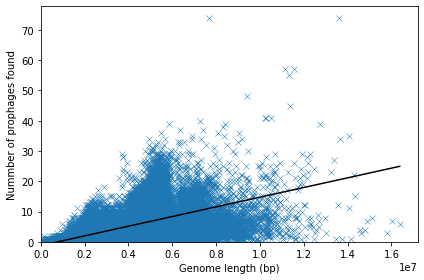

In [12]:
df['kept fit'] = (keptmodel.params['Genome length'] * df['Genome length']) + keptmodel.params['const']
ax = sns.scatterplot(x='Genome length', y='Kept', data=df, marker='x')
sns.lineplot(x='Genome length', y='kept fit', data=df, color='k')
ax.set_ylabel('Nummber of prophages found')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/num_kept.png')

## Compare number of prophages and total prophage bp

This bloody ought to be +ve!

The equation is 19525.179x + 21905.288
The R-squared is 0.795
The p-value for number of phages kept is 0.000


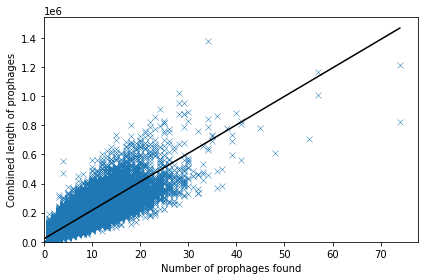

In [13]:
exog = sm.add_constant(df["Kept"])
keptvlen = sm.OLS(df["bp prophage"], exog).fit()
print(f"The equation is {keptvlen.params['Kept']:.3f}x + {keptvlen.params['const']:.3f}")
print(f"The R-squared is {keptvlen.rsquared:.3f}")
print(f"The p-value for number of phages kept is {keptvlen.pvalues['Kept']:.3f}")
df['kept vs bp fit'] = (keptvlen.params['Kept'] * df['Kept']) + keptvlen.params['const']
ax = sns.scatterplot(x='Kept', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Kept', y='kept vs bp fit', data=df, color='k')
ax.set_ylabel('Combined length of prophages')
ax.set_xlabel('Number of prophages found')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/keptpplen.png')

### Is there a relationship between # contigs and # phages?

This could be a relationship, especially as a genome gets fragmented.

In [14]:
exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs total pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']

exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs kept pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']


For TOTAL prophages
The equation is 0.212x + 21.499
The R-squared is 0.221
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is 0.014x + 3.941
The R-squared is 0.035
The p-value for number of phages kept is 0.000


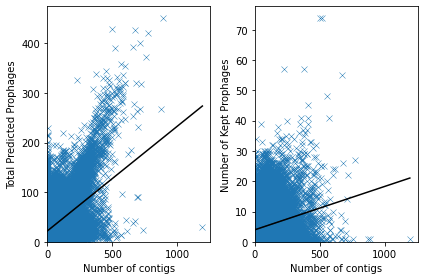

In [15]:
fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=df, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=df, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=df, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=df, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/contigspp.png')

How many contigs are there?

(-10.0, 25.0)

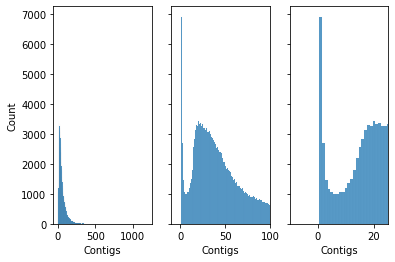

In [43]:
fig, ax =plt.subplots(ncols=3, sharey=True)
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[0])
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[1])
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[2])
ax[1].set_xlim(-10, 100)
ax[2].set_xlim(-10, 25)

#### Repeating, but only for genomes > 20 contigs

I think the graph is being strongly skewed at the bottom.

In [66]:
ndraft = 20
print(f"There are {sum(df['Contigs'] < ndraft):,} contigs less than {ndraft} contigs")

There are 40,430 contigs less than 20 contigs



For TOTAL prophages in draft genomes > 20 contigs
The equation is 0.213x + 21.397 and r**2=0.211

For KEPT prophages
The equation is 0.010x + 4.403 and r**2=0.017


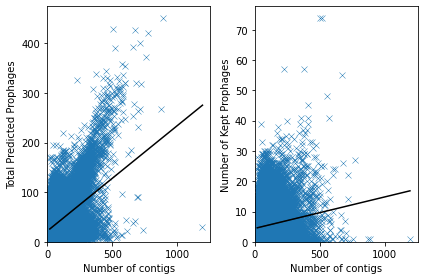

In [16]:
dfdrafts = df[df['Contigs'] > ndraft].copy()
dfdrafts.drop(['contigs vs kept pp', 'contigs vs total pp'], axis=1)
exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Total Predicted Prophages"], exog).fit()
print(f"\nFor TOTAL prophages in draft genomes > {ndraft} contigs")
print(f"The equation is {model.params['Contigs']:.3f}x +b {model.params['const']:.3f} and r**2={model.rsquared:.3f}")

dfdrafts['contigs vs total pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f} and r**2={model.rsquared:.3f}")
dfdrafts['contigs vs kept pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=dfdrafts, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=dfdrafts, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=dfdrafts, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=dfdrafts, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/draftcontigspp.png')

# Filter to sequences with less than 20 contigs

In [67]:
ndraft=20
df = df[df['Contigs'] < ndraft].copy()
df.shape

(40430, 9)

## Some general data about the prophages

In [68]:
print(f"There are {df['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {df['bp prophage'].mean():,.0f} bp, so {df['bp prophage'].mean()/df['Kept'].mean():,.0f} bp per prophage")

There are 3.33 prophages per genome on average, with a mean combined length of 104,207 bp, so 31,332 bp per prophage


In [69]:
print(f"The most prophages is {max(df['Kept'])} in {df.iloc[df['Kept'].argmax()]['Contig']}")
print(f"The longest combined amount of prophage DNA is {max(df['bp prophage'])} in {df.iloc[df['bp prophage'].argmax()]['Contig']}")
print(f"The highest fraction of prophage DNA is {max(df['fraction pp']) * 100:.3f}% in {df.iloc[df['fraction pp'].argmax()]['Contig']}")

The most prophages is 34 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The longest combined amount of prophage DNA is 1381126 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The highest fraction of prophage DNA is 99.829% in GCA_900143735.1_contig1_genomic.gbff.gz


Text(0.5, 0, 'Number of prophages identified')

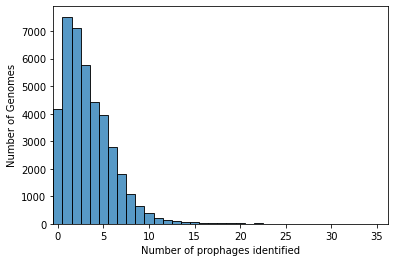

In [70]:
ax = sns.histplot(df['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")

# Filtered Data Set

Lets filter out anything in more than 10 contigs. This should be essentially complete genomes and remove any bias from fragmented genomes

In [72]:
filtermax=10
print(f"Before filtering we have {df.shape[0]:,} genomes")
fdf = df[df['Contigs'] < filtermax].copy()
fdf.reset_index().drop('index', axis=1)
print(f"After filtering for genomes with less than {filtermax} contigs we have {fdf.shape[0]:,} genomes")

Before filtering we have 40,430 genomes
After filtering for genomes with less than 10 contigs we have 17,400 genomes


In [73]:
print(f"After filtering for genomes with less than {filtermax} contigs")
print(f"There are {fdf['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {fdf['bp prophage'].mean():,.0f} bp, so {fdf['bp prophage'].mean()/fdf['Kept'].mean():,.0f} bp per prophage")

After filtering for genomes with less than 10 contigs
There are 3.63 prophages per genome on average, with a mean combined length of 118,865 bp, so 32,790 bp per prophage


In [82]:
print(f"The most prophages is {max(fdf['Kept'])} in {fdf.iloc[fdf['Kept'].argmax()]['Contig']} that has {fdf.iloc[fdf['Kept'].argmax()]['Contigs']} contigs")
print(f"The longest combined amount of prophage DNA is {max(fdf['bp prophage'])} in {fdf.iloc[fdf['bp prophage'].argmax()]['Contig']} that has {fdf.iloc[fdf['bp prophage'].argmax()]['Contigs']} contigs")
print(f"The highest fraction of prophage DNA is {max(fdf['fraction pp']) * 100:.3f}% in {fdf.iloc[fdf['fraction pp'].argmax()]['Contig']}")

The most prophages is 34 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz that has 9 contigs
The longest combined amount of prophage DNA is 1381126 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz that has 9 contigs
The highest fraction of prophage DNA is 99.829% in GCA_900143735.1_contig1_genomic.gbff.gz


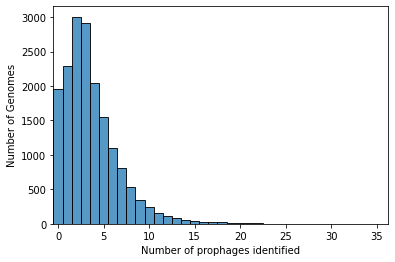

In [75]:
ax = sns.histplot(fdf['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")
fig = ax.get_figure()
fig.savefig('images/pp_hist.png')

### There is no dependency on number of contigs now

When we drop highly fragmented (draft) genomes, we loose the dependency on the number of contigs completely.

In [76]:
fdf.drop(['contigs vs total pp', 'contigs vs kept pp'], axis=1)

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs total pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs kept pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=fdf, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=fdf, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=fdf, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=fdf, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/filteredcontigspp.png')

KeyError: "['contigs vs total pp' 'contigs vs kept pp'] not found in axis"

# Size distributions

This is mostly for Toni Luque who is really interested in the size distributions of the prophages.